Begin by importing necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

print(tf.__version__)
print(tf.keras.__version__)


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

2.10.0
2.10.0


________

Define helper functions

In [2]:
def var_data(dataset, window_size):
    """
    Calculates moving variance on solution
    
    dataset := numpy array, expects form of (no. of solns, length of soln.)
    window_size := int, size of moving window
    """
    
    ## Get shapes of dataset
    n = dataset.shape[0]
    m = dataset.shape[1]

    ## Calculates the amount of steps needed to transfer over
    ##  the solution
    window_steps = m - window_size

    ## Initiates array to hold data
    var_dat = np.zeros((n,window_steps))

    ## Begins moving window
    for j in range(n):
        for i in range(window_steps):
            ## Calculates variance within window
            var_dat[j,i] = dataset[j,i:window_size+i].var()
    
    ## Returns moving variance for user
    return var_dat

def auto_data(dataset, window_size, k=1):
    """
    Calculates autocorrelation of solution
    
    dataset := numpy array, expects form of (no. of solns, length of soln.)
    window_size := int, size of moving windows
    k := int, time step lag between windows (k=1 == lag-1 AC)
    """
    
    ## Get shapes of dataset
    n = dataset.shape[0]
    m = dataset.shape[1]
    
    ## Calculates the amount of steps needed to transfer over
    ##  the solution
    window_steps = m - (window_size + k)

    ## Initiates AC array
    auto_dat = np.zeros((n,window_steps))

    ## Begins moving window
    for j in range(n):
        ## Grabs initial window
        a = dataset[j, 0 :  window_size]
        for i in range(window_steps):
            ## Grabs next window
            b = dataset[j, i + k : i + k + window_size]
            
            ## Calculates the correlation of the windows
            auto_dat[j,i] = np.corrcoef(a,b)[0,1]
            
            ## old window becomes new window
            a = b
    
    # Returns AC to user
    return auto_dat

def trim_data(var, auto, labels, tol, tol1):
    """
    Trims B-tipping data for user. Uses peak in variance as 
        indication that we have passed a tipping point.
    
    var := numpy array, an array containing all the variance data for some solution
    auto := numpy array, ''''' AC data ''' 
    labels := numpy array, ''' the labels for some solution
    tol := int, the amount of values required before max variance has occurred
    tol1 := int, how close to peak in variance we need
    """
    
    ## Initiates 3 temporary lists
    temp1 = []
    temp2 = []
    temp3 = []

    ## Begins loop to trim datasets
    for i in range(len(var)):
        
        ## Finds peak in variance
        end = np.argmax(var[i])
        
        ## Finds starting position for data trimming
        start = end-tol

        ## If peak has 'tol' values before it
        if start > 0:
            
            ## Appends the new trimmed sets to their repsective list
            temp1.append(var[i,start:end-tol1])
            temp2.append(auto[i,start:end-tol1])
            temp3.append(labels[i])
            
    ## Returns trimmed data to user
    return np.array(temp1), np.array(temp2), np.array(temp3) 

def trim_r_data(var, auto, labels, tol, tol1):
    """
    Trims R-tipping data for user. Uses peak in variance as 
        indication that we have passed a tipping point.
    
    var := numpy array, an array containing all the variance data for some solution
    auto := numpy array, ''''' AC data ''' 
    labels := numpy array, ''' the labels for some solution
    tol := int, the amount of values required before max variance has occurred
    tol1 := int, how close to peak in variance we need
    """
    
    temp1 = []
    temp2 = []
    temp3 = []

    for i in range(len(var)):
        ## If solution tips...
        if labels[i] == 1:
            ## Finds peak in variance
            end = np.argmax(var[i])

            ## Finds starting position for data trimming
            start = end-tol

            ## If peak has 'tol' values before it
            if start > 0:

                ## Appends the new trimmed sets to their repsective list
                temp1.append(var[i,start:end-tol1])
                temp2.append(auto[i,start:end-tol1])
                temp3.append(labels[i])

        ## Else, solution never tipped, peak in variance poor indicator
        ##  for data collection
        else:
            ## Take final values instead
            end = -1
            start = end-tol
            
            temp1.append(var[i,start:end-tol1])
            temp2.append(auto[i,start:end-tol1])
            temp3.append(labels[i])

    ## Returns trimmed dataset for the user
    return np.array(temp1), np.array(temp2), np.array(temp3)

## Shorthand defines logistic equation for user.
logistic = lambda x,k=1,x0=0: 1/(1 + np.exp(-k*(x-x0)))


def min_max_norm(data):
    """
    Min-Max normalisation method
    
    data := numpy array, contains a collection of sequences of data
    """
    
    ## Initiates array for user
    min_max_data = np.zeros(data.shape)
    
    ## Calculates min-max norm for each solution
    for i in range(data.shape[0]):
        min_data = data[i].min()
        max_data = data[i].max()
        min_max_data[i] = (data[i] - min_data) / (max_data - min_data)
    
    ## Returns normalised data
    return min_max_data


def z_score_norm(data):
    """
    Min-Max normalisation method
    
    data := numpy array, contains a collection of sequences of data
    """
    
    ## Initiates array for user
    z_score_data = np.zeros(data.shape)
    
    ## Calculates Z-score norm for user
    for i in range(data.shape[0]):
        mean_data = data[i].mean()
        std_data = data[i].std()
        z_score_data[i] = (data[i] - mean_data) / std_data
    
    ## Returns normalised data
    return z_score_data

In [3]:
def show_pred(inp, actual, save_as=None):
    """
    Shows models predictions on some input.
    
    inp := numpy array, time-series input. Shape == (2,85) or (1,2,85)
    actual := numpy array, time-series true value. Shape == (2,15) or (1,2,15)
    save_as := str, name for figure to be saved.
    
    Aside: Shape is dependent on network design. For thesis, it was chosen to be 85 values given, predict on 15.
    """
    
    ## Reshapes inp for LSTM 
    if len(inp.shape) != 3:
        inp = inp.reshape(1,inp.shape[0],inp.shape[1])
    
    if len(actual.shape) != 3:
        actual = actual.reshape(1,actual.shape[0],actual.shape[1])
    
    ## Get model predictions
    res = LSTM.predict(inp, verbose=0)
    n = inp.shape[1]
    
    ## Begins plot definitions
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(inp[0,:,0], label='Input data')
    plt.plot(n, res[0,0,0], 'ro', label='Predicted Value')
    plt.plot(n, actual[0,0,0], 'gs', label='True Value')
    plt.plot(0,0, 'k.', alpha=0, label = 'Probability of tipping = ' + str(predict_tipping(inp)))
    
    for i in range(1, res.shape[1]):
        plt.plot([n+i, n+i], [res[0,i,0], actual[0,i,0]], '0.8')
        plt.plot(n+i, res[0,i,0], 'ro')
        plt.plot(n+i, actual[0,i,0], 'gs')
    
    plt.xlabel('Time', fontsize=17)
    plt.ylabel('Variance', fontsize=17)

    plt.legend()
    
    
    
    plt.subplot(1,2,2)
    plt.plot(inp[0,:,1], label='Input data')
    
    plt.plot(n, res[0,0,1], 'ro')
    plt.plot(n, actual[0,0,1], 'gs')
    
    for i in range(1, res.shape[1]):
        plt.plot([n+i, n+i], [res[0,i,1], actual[0,i,1]], '0.8')
        plt.plot(n+i, res[0,i,1], 'ro')
        plt.plot(n+i, actual[0,i,1], 'gs')
    
    plt.xlabel('Time', fontsize=17)
    plt.ylabel('AC', fontsize=17)
    
    
    plt.ylim(-1.1,1.1)
    
    if save_as != None:
        plt.savefig(save_as, dpi=300)
    
    plt.show()

Begin by reading in data generated in `Generated Data.ipynb`

In [4]:
#dataset = np.genfromtxt('dataset.csv', delimiter=',')

data = np.genfromtxt('Datasets/dataset_part1.csv', delimiter=',')
data1 = np.genfromtxt('Datasets/dataset_part2.csv', delimiter=',')

## These two data sets were produced and have additional noise.
data2 = np.genfromtxt('Datasets/dataset_part1_alt.csv', delimiter=',')
data3 = np.genfromtxt('Datasets/dataset_part2_alt.csv', delimiter=',')

dataset = np.array([data, data1, data2, data3])

## Reshapes entire dataset to be of shape (P,M)
dataset = np.reshape(dataset, (data.shape[0] + data1.shape[0] + data2.shape[0] + data3.shape[0], data.shape[1]))

dataset.shape

(10000, 1001)

Plotting a few samples of the dataset.

Red indicates a system which tipped, blue indicates a system which has not tipped.

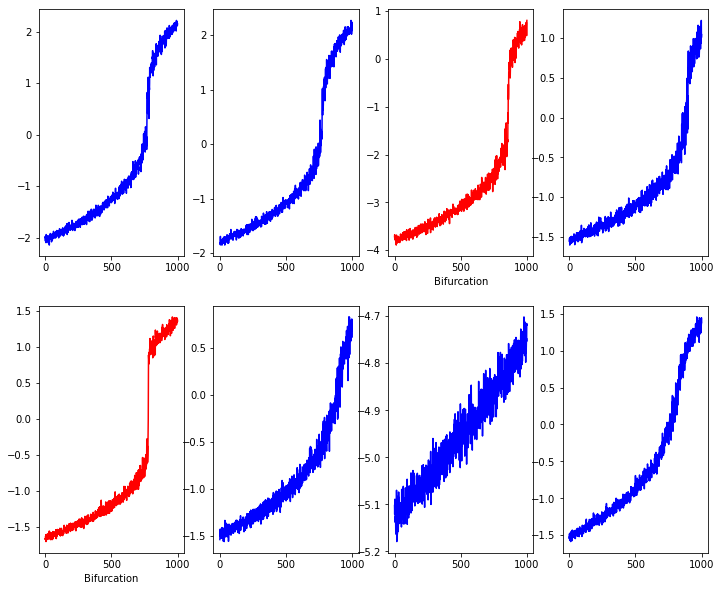

In [5]:
plt.figure(1,(12,10))
for i in range(1, 9):
    plt.subplot(2,4,i)
    k = np.random.randint(0,dataset.shape[0])
    if dataset[k,0] == 1:
        plt.plot(dataset[k,1:], 'r')
        plt.xlabel("Bifurcation")
    else:
        plt.plot(dataset[k,1:], 'b')

Shuffle dataset. As of now, data is mostly organised

In [6]:
rng = np.random.default_rng()
rng.shuffle(dataset)

dataset, sum(dataset[:,0])

(array([[ 1.        , -2.05186749, -2.11773165, ...,  1.5914643 ,
          1.58542848,  1.69807974],
        [ 1.        , -1.89361795, -1.87725758, ...,  1.5104619 ,
          1.60170885,  1.62515901],
        [ 0.        , -1.45710245, -1.50823244, ...,  0.68865565,
          0.79636448,  0.96250182],
        ...,
        [ 1.        , -2.96421191, -2.86010447, ...,  1.68727728,
          1.89028268,  1.752684  ],
        [ 1.        , -3.34038214, -3.26419656, ..., -2.38565532,
         -2.36763977, -2.37381207],
        [ 0.        , -1.32652102, -1.35299677, ...,  1.53210915,
          1.52272281,  1.51353629]]),
 4621.0)

Splitting dataset into variance, AC and labels.

Labels indicate whether a solution has tipped or not.

In [7]:
dataset = np.genfromtxt('Datasets/shuffle_dataset.csv', delimiter=',')
var_dat = np.genfromtxt('Datasets/var_dat.csv', delimiter=',')
auto_dat = np.genfromtxt('Datasets/auto_dat.csv', delimiter=',')

labels = dataset[:,0].astype(int)

# n = int(dataset.shape[1] * 0.1)
# k = 1

# var_dat = var_data(dataset[:,1:], n)

# auto_dat = auto_data(dataset[:,1:], n-k, k)

dataset.shape, var_dat.shape, auto_dat.shape

((1000, 1001), (1000, 900), (1000, 900))

Previous cell can take considerable amount of time, save outputs when re-running data/image creation.

In [8]:
# np.savetxt('shuffle_dataset.csv', dataset, delimiter=',')
# np.savetxt('var_dat.csv', var_dat, delimiter=',')
# np.savetxt('auto_dat.csv', auto_dat, delimiter=',')

Plot variance and AC. Colours again represent whether a tipping point occurred or not.

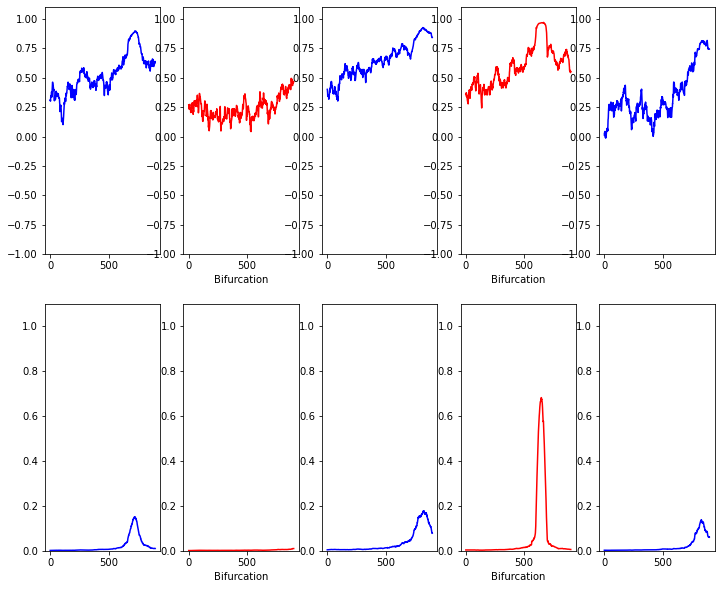

In [9]:
plt.figure(1,(12,10))
for i in range(1, 6):
    plt.subplot(2,5,i)
    k = np.random.randint(0,var_dat.shape[0])
    if labels[k] == 1:
        plt.plot(auto_dat[k], 'r')
        plt.xlabel("Bifurcation")
    else:
        plt.plot(auto_dat[k], 'b')
    plt.ylim((-1,1.1))

    plt.subplot(2,5,i+5)
    
    if labels[k] == 1:
        plt.plot(var_dat[k], 'r')
        plt.xlabel("Bifurcation")
    else:
        plt.plot(var_dat[k], 'b')
    plt.ylim((0,1.1))

Trim dataset to contain only solutions we are interested in.

In [10]:
trimmed_var, trimmed_auto, trimmed_labels = trim_data(var_dat, auto_dat, labels, tol=135, tol1=35)

In [11]:
var_dat.shape, trimmed_var.shape, trimmed_auto.shape, trimmed_labels.shape

((1000, 900), (998, 100), (998, 100), (998,))

Plot trimmed solutions to show difference.

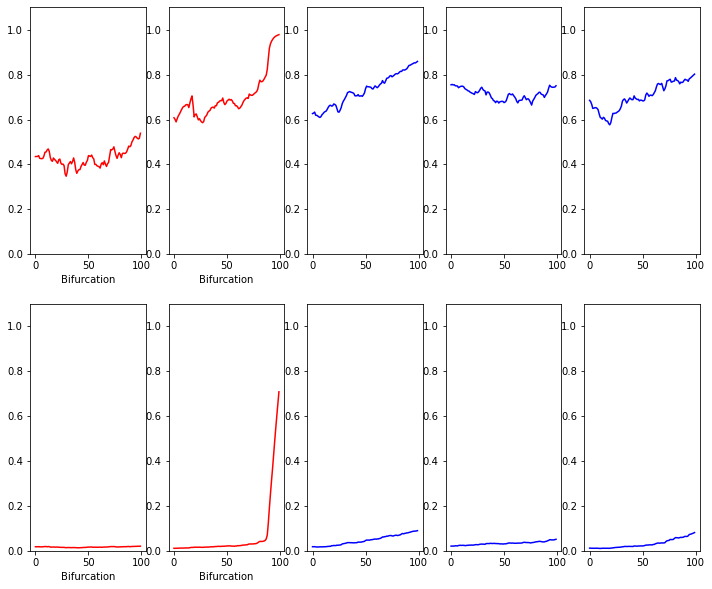

In [12]:
plt.figure(1,(12,10))
for i in range(1, 6):
    plt.subplot(2,5,i)
    k = np.random.randint(0,var_dat.shape[0])
    if trimmed_labels[k] == 1:
        plt.plot(trimmed_auto[k], 'r')
        plt.xlabel("Bifurcation")
    else:
        plt.plot(trimmed_auto[k], 'b')
    plt.ylim((0,1.1))

    plt.subplot(2,5,i+5)
    
    if trimmed_labels[k] == 1:
        plt.plot(trimmed_var[k], 'r')
        plt.xlabel("Bifurcation")
    else:
        plt.plot(trimmed_var[k], 'b')
    plt.ylim((0,1.1))

We look at the distribution of the max values of variance. Large outliers in the dataset could cause the network to underfit the data.

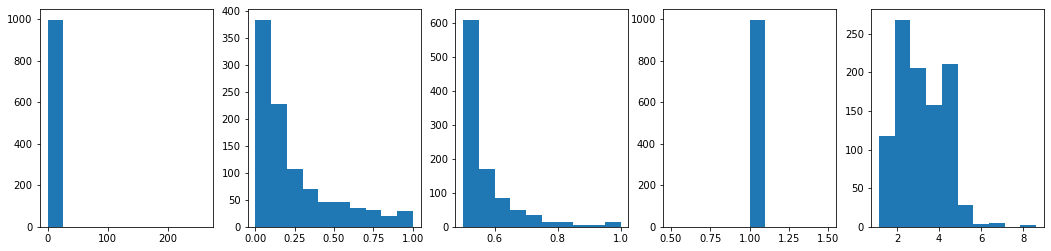

In [13]:
plt.figure(figsize=(18,4))
plt.subplot(1,5,1)
plt.hist(np.amax(trimmed_var, axis=1))

plt.subplot(1,5,2)
plt.hist(np.amax(np.tanh(trimmed_var), axis=1))

plt.subplot(1,5,3)
plt.hist(np.amax(logistic(trimmed_var), axis=1))

plt.subplot(1,5,4)
plt.hist(np.amax(min_max_norm(trimmed_var), axis=1))

plt.subplot(1,5,5)
plt.hist(np.amax(z_score_norm(trimmed_var), axis=1))

plt.show()

Choose Z-score norm as it provides the best distribution.

In [14]:
normalised_var = z_score_norm(trimmed_var)

Combine variance and AC together.
Reshape the array for training

In [15]:
data = np.zeros((normalised_var.shape[0], 2, normalised_var.shape[1]))

for i in range(trimmed_var.shape[0]):
    data[i,0] = normalised_var[i]
    data[i,1] = trimmed_auto[i]

data.shape, normalised_var[0,:10], trimmed_auto[0,:10], data[0,0,0:10], data[0,1,0:10]

((998, 2, 100),
 array([-1.31313015, -1.3387441 , -1.2925307 , -1.30563096, -1.30419997,
        -1.25404349, -1.25329939, -1.18100741, -1.1700392 , -1.07360462]),
 array([0.59982031, 0.60863932, 0.62035176, 0.61316464, 0.60528162,
        0.61461922, 0.60853113, 0.60291109, 0.60580814, 0.60919072]),
 array([-1.31313015, -1.3387441 , -1.2925307 , -1.30563096, -1.30419997,
        -1.25404349, -1.25329939, -1.18100741, -1.1700392 , -1.07360462]),
 array([0.59982031, 0.60863932, 0.62035176, 0.61316464, 0.60528162,
        0.61461922, 0.60853113, 0.60291109, 0.60580814, 0.60919072]))

Split data into $70:20:10$; train, validation and test

In [16]:
n = normalised_var.shape[0]
train_labels = trimmed_labels[:int(0.7*n)]
val_labels = trimmed_labels[int(0.7*n):int(0.9*n)]
test_labels = trimmed_labels[int(0.9*n):]
test_labels[:10]

train_dat = data[:int(0.7*n)]
val_dat = data[int(0.7*n):int(0.9*n)]
test_dat = data[int(0.9*n):]

In [17]:
test_dat.shape, test_labels.shape

((100, 2, 100), (100,))

## MLP and CNN

Using MLP and CNN's to discern if a fold bifurcation has occurred or not.

In [18]:
inputs = keras.Input(shape=(train_dat.shape[1:]), name="Variance and AC")

x = layers.Dense(128, activation='relu')(inputs)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model_MLP = keras.Model(inputs, outputs, name="ANN")

## Compile model
model_MLP.compile(optimizer='adam', 
              loss = 'mse',
              metrics=['accuracy'])

## Relay model summary to user
model_MLP.summary()

## Train model
model_MLP.fit(train_dat, train_labels, validation_data = (val_dat, val_labels), batch_size=32, epochs=30, verbose=0)

## Evalute model accuracy
test_loss, test_acc = model_MLP.evaluate(test_dat, test_labels)

Model: "ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Variance and AC (InputLayer  [(None, 2, 100)]         0         
 )                                                               
                                                                 
 dense (Dense)               (None, 2, 128)            12928     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 29,441
Trainable params: 29,441
Non-trainable params: 0
___________________________________________________________

In [19]:
inputs = keras.Input(shape=(train_dat.shape[1:]), name="Variance and AC")

x = layers.Conv1D(64, 1, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(64, 1, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model_CNN = keras.Model(inputs, outputs, name="CNN")


## Compile model
model_CNN.compile(optimizer='adam', 
              loss = 'mse',
              metrics=['accuracy'])

## Relay model summary to user
model_CNN.summary()

## Train model
model_CNN.fit(train_dat, train_labels, validation_data = (val_dat, val_labels), epochs=5, verbose=0)

## Evalute model accuracy
test_loss, test_acc = model_CNN.evaluate(test_dat, test_labels)

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Variance and AC (InputLayer  [(None, 2, 100)]         0         
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 2, 64)             6464      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65      

_____

## LSTM's

Need to reshape to [Samples, Time Steps, Features]

EX
[~1000 Samples, (5 Var Timesteps, 5 Auto Timesteps), (Next Variance,  Next AutoCor)]

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [20]:
def create_time_series(data, steps_back=5, steps_forward=1, features = 2):
    """Creates time series from set of data.
        Takes in sample of data, creates time series of final (step_forward + step_back) steps.
        
        data := array, has form (# samples, # features, # time steps)
        steps_back, steps_forward := int, amount of steps_back used to guess steps_forward
        features := amount of features present in the data (ex. variance and autocorrelation)
        
        Returns 2 arrays, where 'X' consists of (t-step_back, ..., t-1)
                                'y' consists of (t)
        """
    
    ## Initialise arrays for data
    ##  Has shape (sample, timesteps, features)
    X = np.zeros((data.shape[0],steps_back,features))
    y = np.zeros((data.shape[0],steps_forward,features))
    
    ## Begin loop for each sample
    for i in range(data.shape[0]):
        ## ... and each feature
        for j in range(features):
            X[i,:,j] = data[i,j,-(steps_back+steps_forward):-steps_forward]
            y[i,:,j] = data[i,j,-steps_forward:]
    
    return X,y

Making data a time-series

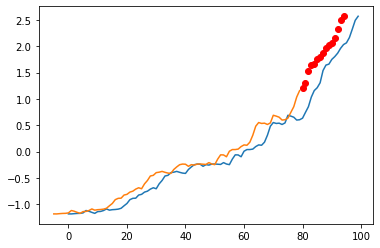

((998, 85, 2), (998, 15, 2))

In [21]:
steps_back = 85
steps_forward = 15
features = data.shape[1]

X,y = create_time_series(data, steps_back, steps_forward, features)

## Plotting output for user
k = np.random.randint(0, 100)
plt.plot(data[k,0])
plt.plot(np.arange(data.shape[2]-steps_forward-5, data.shape[2]-5), y[k,:,0], 'ro')
plt.plot(np.arange(data.shape[2]-(steps_back+steps_forward)-5, data.shape[2] - steps_forward-5), X[k,:,0])

plt.show()
X.shape, y.shape

Split data into $70:20:10$; train, validation and test

In [22]:
n = X.shape[0]

train_X = X[:int(0.7*n)]
val_X = X[int(0.7*n):int(0.9*n)]
test_X = X[int(0.9*n):]


train_y = y[:int(0.7*n)]
val_y = y[int(0.7*n):int(0.9*n)]
test_y = y[int(0.9*n):]


In [23]:
train_X.shape, train_y.shape

((698, 85, 2), (698, 15, 2))

Begin training LSTM

In [24]:
inputs = keras.Input(shape=train_X.shape[1:], name="data")

x = layers.LSTM(64, activation='relu')(inputs)
x = layers.RepeatVector(steps_forward)(x)
x = layers.LSTM(32, activation='relu', return_sequences=True)(x)
x = layers.Dense(32)(x)
outputs = layers.TimeDistributed(layers.Dense(features))(x)


LSTM = keras.Model(inputs, outputs, name="LSTM")

## Compile model
LSTM.compile(optimizer='adam', 
              loss = 'mse')

## Relay model summary to user
LSTM.summary()

## Train model
history = LSTM.fit(train_X, train_y, validation_data = (val_X, val_y), epochs=100, verbose=1)

## Evalute model accuracy
test_loss = LSTM.evaluate(test_X, test_y)

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data (InputLayer)           [(None, 85, 2)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 repeat_vector (RepeatVector  (None, 15, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            12416     
                                                                 
 dense_4 (Dense)             (None, 15, 32)            1056      
                                                                 
 time_distributed (TimeDistr  (None, 15, 2)            66        
 ibuted)                                                      

Make interactive widget for user to see predictions

In [50]:
@interact(k=(0,len(test_X),1))
def g(k):
    show_pred(test_X[k], test_y[k])

interactive(children=(IntSlider(value=50, description='k'), Output()), _dom_classes=('widget-interact',))

Next, need to produce predictions for the CNN to learn off of.

In [26]:
lstm_train_pred = LSTM.predict(train_X)
lstm_val_pred = LSTM.predict(val_X)
lstm_test_pred = LSTM.predict(test_X)

lstm_train_pred.shape, train_labels.shape

4/4 [==============================] - 0s 11ms/step


((698, 15, 2), (698,))

In [27]:
inputs = keras.Input(shape=(lstm_train_pred.shape[1:]), name="LSTM_data")

x = layers.Conv1D(64, 2, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(32, 2, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(64)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model_CNN = keras.Model(inputs, outputs, name="CNN")


## Compile model
model_CNN.compile(optimizer='adam', 
              loss = 'mse',
              metrics=['accuracy'])

## Relay model summary to user
model_CNN.summary()

## Train model
model_CNN.fit(lstm_train_pred, train_labels, validation_data = (lstm_val_pred, val_labels), epochs=100, verbose=0)

## Evalute model accuracy
test_loss, test_acc = model_CNN.evaluate(lstm_test_pred, test_labels)

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_data (InputLayer)      [(None, 15, 2)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 14, 64)            320       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 6, 32)             4128      
                                                                 
 flatten_2 (Flatten)         (None, 192)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                12352     
                                                               

Using LSTM and CNN, can ask to predict tipping point.

In [28]:
def predict_tipping(time_series):
    
    if len(time_series.shape) != 3:
        time_series = time_series.reshape(1,time_series.shape[0],time_series.shape[1])
    LSTM_pred = LSTM.predict(time_series, verbose=0)
    CNN_pred = model_CNN.predict(LSTM_pred, verbose=0)
    
    return CNN_pred[0,0]

Ask model to predict on a random test solution.

Returns model prediction and true answer.

In [29]:
k=np.random.randint(0,len(test_X))

pred = predict_tipping(test_X[k])

print("Probability of tipping is" , pred)
if test_labels[k] == 0:
    print("Tipping did not occur")
else:
    print("Tipping did occur")

Probability of tipping is 0.99256974
Tipping did occur


Save models for use in `thermoacoustic_testing.ipynb`

In [30]:
# LSTM.save('lstm_model', save_format='h5'), model_CNN.save('cnn_model', save_format='h5')

Visualising the performance of networks by using ROC curves

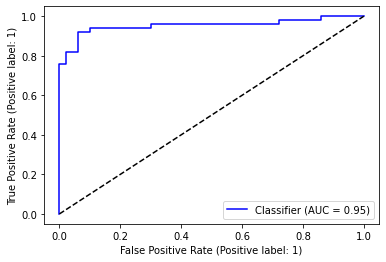

In [31]:
LSTM_pred = LSTM.predict(test_X, verbose=0)
CNN_pred = model_CNN.predict(LSTM_pred, verbose=0)

preds = CNN_pred

RocCurveDisplay.from_predictions(test_labels, preds, color='b')
plt.plot([0,1],[0,1], 'k--')
#plt.savefig('ROC_bntip.pdf', dpi=300)
plt.show()


Evaluate LSTM predictions.

In [32]:
X,y = create_time_series(data, steps_back, steps_forward, features)
test_X, test_y = X[int(0.9*n):], y[int(0.9*n):]
LSTM.evaluate(test_X, test_y)

4/4 [==============================] - 0s 12ms/step - loss: 0.0517


0.05173095688223839

____

## R-Tipping Prediction

Next, we look at predicting R-tipping.

We begin by reading in data generated from `R-Tipping.ipynb`

In [33]:
data_r = np.genfromtxt('Datasets/data_rtip.csv', delimiter=',')
data_r.shape

(1000, 1001)

Visualising sample solutions from dataset. Red represents systems which tipped, while blue represents systems which have not tipped.

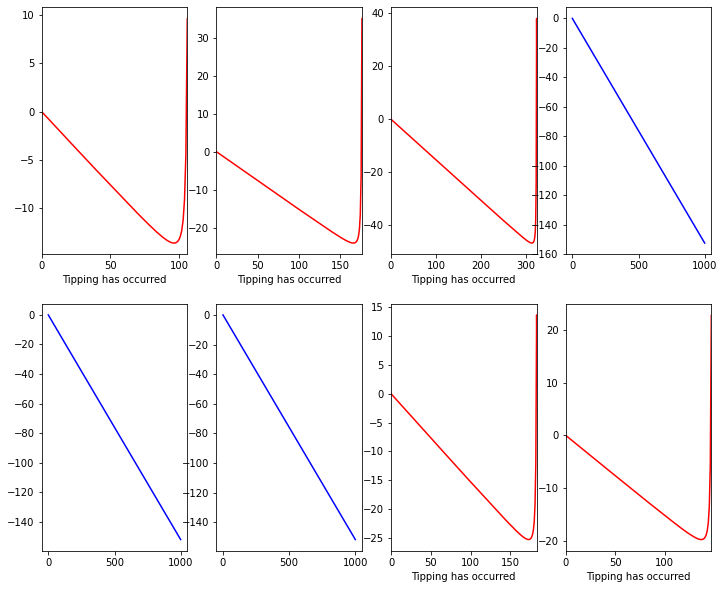

In [34]:
plt.figure(1,(12,10))
for i in range(1, 9):
    plt.subplot(2,4,i)
    k = np.random.randint(0,data_r.shape[0])
    if data_r[k,0] == 1:
        plt.plot(data_r[k,1:], 'r')
        plt.xlim(-0.01,np.argmax(data_r[k,1:]))
        plt.xlabel("Tipping has occurred")
    else:
        plt.plot(data_r[k,1:], 'b')

Splitting a solution into variance, AC and labels as before

In [35]:
r_var_dat = np.genfromtxt('Datasets/r_var_dat.csv', delimiter=',')
r_auto_dat = np.genfromtxt('Datasets/r_auto_dat.csv', delimiter=',')

r_labels = data_r[:,0].astype(int)

# n = int(data_r.shape[1] * 0.1)
# k = 1

# r_var_dat = var_data(data_r[:,1:], n)

# r_auto_dat = auto_data(data_r[:,1:], n-k, k)


data_r.shape, r_var_dat.shape, r_auto_dat.shape

((1000, 1001), (1000, 900), (1000, 900))

Again, previous cell takes time, may be better to save result for future running/image creation.

In [36]:
# np.savetxt('r_var_dat.csv', r_var_dat, delimiter=',')
# np.savetxt('r_auto_dat.csv', r_auto_dat, delimiter=',')

Depicting sample variance and AC

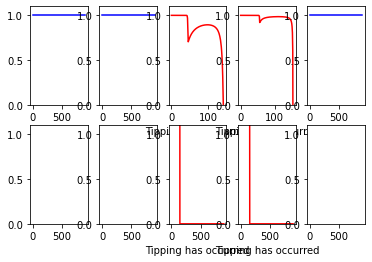

In [37]:
for i in range(1, 6):
    plt.subplot(2,5,i)
    k = np.random.randint(0,r_var_dat.shape[0])
    if r_labels[k] == 1:
        plt.plot(r_auto_dat[k], 'r')
        plt.xlabel("Tipping has occurred")
    else:
        plt.plot(r_auto_dat[k], 'b')
    plt.ylim((0,1.1))

    plt.subplot(2,5,i+5)
    
    if r_labels[k] == 1:
        plt.plot(r_var_dat[k], 'r')
        plt.xlabel("Tipping has occurred")
    else:
        plt.plot(r_var_dat[k], 'b')
    plt.ylim((0,1.1))

Trimming and normalising dataset as we did before

In [38]:
trimmed_r_var, trimmed_r_auto, trimmed_r_labels = trim_r_data(r_var_dat, r_auto_dat, r_labels, 135,35)

In [39]:
normalised_rvar = z_score_norm(trimmed_r_var)

In [40]:
normalised_rvar.shape

(578, 100)

Check amount of tipping systems still present.

In [41]:
np.sum(trimmed_r_labels)

207

Depicting more sample variances and AC

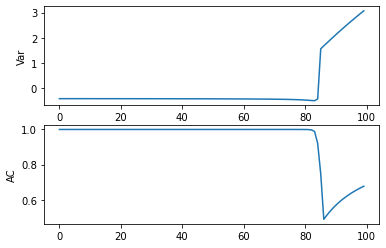

In [42]:
k = np.random.randint(0, normalised_rvar.shape[0])

plt.subplot(2,1,1)
plt.plot(normalised_rvar[k], label='var')
plt.ylabel('Var')

plt.subplot(2,1,2)
plt.plot(trimmed_r_auto[k], label='auto')
plt.ylabel('AC')

plt.show()

Constructing dataset as before

In [43]:
test_r = np.zeros((normalised_rvar.shape[0], 2, normalised_rvar.shape[1]))

for i in range(trimmed_r_auto.shape[0]):
    test_r[i,0] = normalised_rvar[i]
    test_r[i,1] = trimmed_r_auto[i]

test_r.shape, normalised_rvar[0,:10], trimmed_r_auto[0,:10], test_r[0,0,0:10], test_r[0,1,0:10]

((578, 2, 100),
 array([-1.80874871, -1.75961399, -1.68061268, -1.61292279, -1.50540573,
        -1.42928342, -1.35939627, -1.27311369, -1.19726511, -1.1245832 ]),
 array([0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
        0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994]),
 array([-1.80874871, -1.75961399, -1.68061268, -1.61292279, -1.50540573,
        -1.42928342, -1.35939627, -1.27311369, -1.19726511, -1.1245832 ]),
 array([0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
        0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994]))

Creating time-series from dataset.

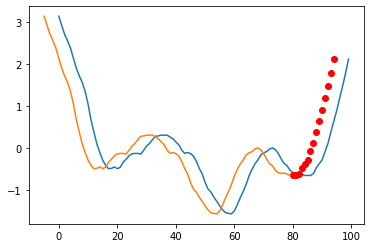

((578, 85, 2), (578, 15, 2))

In [44]:
steps_back = 85
steps_forward = 15
features = test_r.shape[1]

test_rX, test_ry = create_time_series(test_r, steps_back, steps_forward, features)
k = np.random.randint(0, 20)
plt.plot(test_r[k,0])
plt.plot(np.arange(test_r.shape[2]-steps_forward-5, test_r.shape[2]-5), test_ry[k,:,0], 'ro')
plt.plot(np.arange(test_r.shape[2]-(steps_back+steps_forward)-5, test_r.shape[2] - steps_forward-5), test_rX[k,:,0])

plt.show()
test_rX.shape, test_ry.shape

Interactable widget for user to look at model predictions

In [45]:
@interact(k=(0,test_rX.shape[0],1))
def g(k):
    show_pred(test_rX[k], test_ry[k])

interactive(children=(IntSlider(value=289, description='k', max=578), Output()), _dom_classes=('widget-interac…

Probability of tipping is 0.031741515
Tipping did not occur


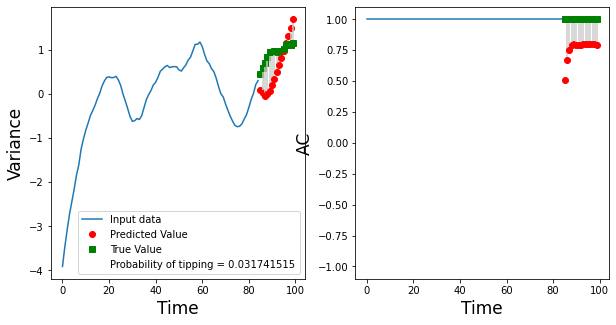

In [46]:
k = np.random.randint(0,test_rX.shape[0])
pred = predict_tipping(test_rX[k])

print("Probability of tipping is" , pred)

if trimmed_r_labels[k] == 0:
    print("Tipping did not occur")
else:
    print("Tipping did occur")

show_pred(test_rX[k], test_ry[k])

Get ROC curve for LSTM-CNN on R-tipping data

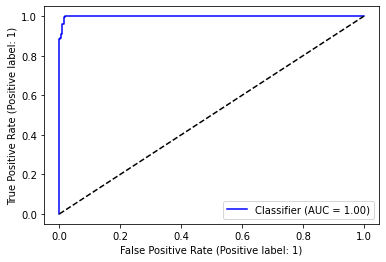

In [47]:
LSTM_pred = LSTM.predict(test_rX, verbose=0)
CNN_pred = model_CNN.predict(LSTM_pred, verbose=0)

preds = CNN_pred

RocCurveDisplay.from_predictions(trimmed_r_labels, preds, color='b')
plt.plot([0,1],[0,1], 'k--')
#plt.savefig('ROC_rtip.pdf', dpi=300)
plt.show()

Another model save checkpoint

In [48]:
#LSTM.save('lstm_model', save_format='h5'), model_CNN.save('cnn_model', save_format='h5')

Evaluating LSTM on R-tipping

In [49]:
test_rX, test_ry = create_time_series(test_r, steps_back, steps_forward, features)

LSTM.evaluate(test_rX, test_ry, verbose=1)

19/19 [==============================] - 0s 12ms/step - loss: 1.0855


1.0855426788330078